<a href="https://colab.research.google.com/github/greyhound101/shopee/blob/main/swa_lrs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class stocasticensembling(Callback):
  def __init__(self,model_name,alpha1,alpha2,iter_per_epoch,cycle_len,seqs_dict,start_inx=0,save_se_weights=False,folder='/content',**kwargs):
    #save_se_weights: save after each epoch ?

    super(stocasticensembling,self).__init__()
    self.alpha1=alpha1
    self.alpha2=alpha2
    self.clr_iterations=0
    self.cycle_num=cycle_len
    self.cycle_len=cycle_len
    self.iter_per_epoch=iter_per_epoch
    self.iter_per_cycle = self.cycle_len * self.iter_per_epoch
    self.start_inx=start_inx
    
  def on_train_end(self,logs={}):
    self.weight_update()
    self.model.set_weights(self.swa_weights)
    
  
  
  def on_epoch_end(self,epoch,logs=None):
    self.cycle_num+=1
    if (self._t_cycle() !=1) or (epoch<self.start_inx):
      return
    self.weight_update()
    self.model_count+=1
  
  
  def on_batch_begin(self,batch,logs=None):
    if self.cycle_num<self.start_inx:
      self.clr_iterations+=1
      lr=self._clr_schedule()
      K.set_value(self.model.optimizer.lr,lr)
  
  
  
  def weight_update(self):
    weights=self.model.get_weights()
    if self.model_count==0:
      self.swa_weights=weights
    for i in range(0,len(weights)):
      self.swa_weights[i]=(self.swa_weights[i]*self.model_count+weights[i])/(self.model_count+1)
  
  
  def _t_cycle(self):
        return (((self.clr_iterations - 1) % self.iter_per_cycle) + 1) / self.iter_per_cycle
  
  
  def _clr_schedule(self):
    return ((1.0 - 1.0 *self._t_cycle()) * self.alpha2) + (1.0 *self._t_cycle() *self.alpha1)

In [65]:
lr_start   = 0.000001
lr_max     = 0.000005 * 128
lr_min     = 0.000001
lr_ramp_ep = 5
lr_sus_ep  = 0
lr_decay   = 0.8
cycle_len=2
iter_per_epoch=108
alpha1=lr_min
alpha2=lr_min*10

In [66]:
iter_per_cycle = cycle_len * iter_per_epoch
iter_per_cycle

216

In [70]:
def _t_cycle():
        return (((clr_iterations - 1) % iter_per_cycle) + 1) /iter_per_cycle
  
  
def _clr_schedule():
    if cycle_num>swa_cycle_start_inx:
      return ((1.0 - 1.0 *_t_cycle()) * alpha2) + (1.0 *_t_cycle() *alpha1)
    else:
      if cycle_num < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * cycle_num + lr_start   
      elif cycle_num < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
      else:
            lr = (lr_max - lr_min) * lr_decay**(cycle_num - lr_ramp_ep - lr_sus_ep) + lr_min   
      return lr

In [71]:
ls=[]
swa_cycle_start_inx=15
for cycle_num in range(20):
  for x in range(108):
    clr_iterations = x+108 *cycle_num
    lr=_clr_schedule()
    ls.append(lr)

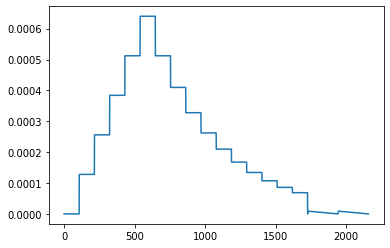

In [72]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.plot(ls)